In [107]:
import pickle
import random
import multiprocessing 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import cv2
import random

In [108]:
class Settings:
    @classmethod
    def show_img(cls, img, figsize=(8, 4), subplot=(1, 2, 1)):
        plt.figure(figsize=figsize)
        plt.subplot(*subplot)
        plt.imshow(img, cmap="gray", interpolation='nearest')
        plt.show()

    @classmethod
    def randomize_images(cls, x_datas, y_datas=None):
        new_x_datas = np.zeros_like(x_datas)
        new_y_datas = np.zeros_like(y_datas)

        for i, data in enumerate(tqdm(x_datas)):
            _data = x_datas[i].reshape(28, 28) 

            # Random scale
            scale_factor = np.random.uniform(0.9, 1.1)
            scaled_image = cv2.resize(_data, None, fx=scale_factor, fy=scale_factor)

            # Random rotation
            angle = np.random.uniform(-45, 45)
            rows, cols = _data.shape
            rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            rotated_image = cv2.warpAffine(scaled_image, rotation_matrix, (cols, rows))

            # Random translation (offset)
            dx, dy = np.random.randint(-2, 2, size=2)  # Random integers between -2 and 2 for x and y translation
            translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])  # Translation matrix
            translated_image = cv2.warpAffine(rotated_image, translation_matrix, (cols, rows))

            # Add a little bit of noise
            probability = random.uniform(0, 0.1)
            noise_mask = np.random.random(translated_image.shape) <= probability
            noise_strength = np.random.random(translated_image.shape) - 0.5
            noise_value = translated_image * noise_strength
            noisy_image = np.clip(translated_image + np.where(noise_mask, noise_value + noise_strength, translated_image), 0, 1)

            if y_datas is not None:
                new_x_datas[i] = noisy_image.reshape(1, -1)
                new_y_datas[i] = np.array([y_datas[i]])
            else:
                x_datas[i] = noisy_image.reshape(784)

        if y_datas is not None:
            x_datas = np.concatenate((x_datas, new_x_datas), axis=0)
            y_datas = np.concatenate((y_datas, new_y_datas), axis=0)

        return x_datas, y_datas


In [109]:
class ActivationLayer:
    """
    Aktivasyon katmanlarini iceren Static Fonksiyon 
    """
    @classmethod
    def ReLU(cls, Z):
        return np.maximum(0, Z)
    
    @classmethod
    def softmax(cls, Z):
        out = np.exp(Z)
        return out/np.sum(out)

    @classmethod
    def sigmoid(cls, Z):
        Z_clipped = np.clip(Z, -255, 255)
        return 1 / (1 + np.exp(-Z_clipped))

In [110]:
class PoolLayer2D:
    """
    Pooling Katmani goruntunu boyutunu dusurmeye yarar 
    """
    def nanargmax(self, arr):
        idx = np.nanargmax(arr)
        idxs = np.unravel_index(idx, arr.shape)
        return idxs    

    def maxpool(self, image, kernel_size=2, stride=2):
        (imageChannel, ix, iy) = image.shape

        w = int((ix - kernel_size)/stride)+1
        h = int((iy - kernel_size)/stride)+1

        output = np.zeros((imageChannel, w, h))

        for n in range(imageChannel): 
            out_x = 0
            for x in range(0, ix - kernel_size + 1, stride):
                out_y = 0
                for y in range(0, iy - kernel_size + 1, stride):
                    output[n, out_x, out_y] = np.max(image[n, x:x+kernel_size, y:y+kernel_size])
                    out_y += 1
                out_x += 1

        return output
    

    def maxpoolBackward(self, dPool, conv_in, kernel_size, stride):
        (imageChannel, ix, iy) = conv_in.shape

        output = np.zeros(conv_in.shape)

        for n in range(imageChannel): 
            out_x = 0
            for x in range(0, ix - kernel_size + 1, stride):
                out_y = 0
                for y in range(0, iy - kernel_size + 1, stride):
                    (a, b) = self.nanargmax(conv_in[n, x:x+kernel_size, y:y+kernel_size])
                    output[n, x+a, y+b] = dPool[n, out_x, out_y]
                    out_y += 1
                out_x += 1

        return output

In [111]:
class Convolution2D:
    """
    2D convolution katman implemantasyonu.
    """
    def convolution(self, image, kernel, bias, stride=1):
        """
        Kernel'lerin (Filtrelerin) uygulanarak ozellik ortaya cikmasini saglar
        kernel kadar output cikisi olur  
        """
        (numberOfFilter, filterChannel, fx, fy) = kernel.shape
        (imageChannel, ix, iy) = image.shape

        output_shape = int((ix - fx) / stride) + 1
        output = np.zeros((numberOfFilter, output_shape, output_shape))

        for n in range(numberOfFilter):
            out_x = 0
            for x in range(0, ix - fx + 1, stride):
                out_y = 0
                for y in range(0, iy - fy + 1, stride):
                    output[n, out_x, out_y] = np.sum(np.multiply(kernel[n], image[:, x:x+fx, y:y+fy])) + bias[n, 0]
                    out_y += 1
                out_x += 1

        return output
        
    def convolutionBackward(self, dConv_prev, conv_in, kernel, stride):
        (numberOfFilter, filterChannel, fx, fy) = kernel.shape
        (imageChannel, ix, iy) = conv_in.shape

        dOut = np.zeros(conv_in.shape)
        dFilt = np.zeros(kernel.shape)
        dBias = np.zeros((numberOfFilter, 1))

        for n in range(numberOfFilter):
            out_x = 0
            for x in range(0, ix - fx + 1, stride):
                out_y = 0
                for y in range(0, iy - fy + 1, stride):
                    dOut[:, x:x+fx, y:y+fy] += dConv_prev[n, out_x, out_y] * kernel[n]
                    dFilt[n] += dConv_prev[n, out_x, out_y] * conv_in[:, x:x+fx, y:y+fy]
                    out_y += 1
                out_x += 1
        
            dBias[n] = np.sum(dConv_prev[n])

        return dOut, dFilt, dBias


In [112]:
class CNN:
    """
    Convulution islemi tamamlandiktan sonra
    Fully Connected Layer adimini bu class' ta gerceklestiri
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
               kernel_size=(5, 5), pool_size: tuple = (2, 2),
               img_depth: int = 1, num_filt2: int = 5, num_filt1: int = 5,
               alpha: float = 0.005):

        
        self.X = X
        self.y = y
        self.train_data = np.hstack((X, y))
        self.X_val = X_val
        self.y_val = y_val

        self.pool_size = pool_size
        self.kernel_size = kernel_size
        self.img_depth = img_depth
        self.num_filt2 = num_filt2
        self.num_filt1 = num_filt1
        self.alpha = alpha

        self.init_params()

    def init_params(self):
        self.conv2D = Convolution2D()
        self.pool2D = PoolLayer2D()

        self.f1, self.f2, self.w3, self.w4 = (self.num_filt1 ,self.img_depth,*self.kernel_size), (self.num_filt2 ,self.num_filt1,*self.kernel_size), (10, 500), (10, 10)
        self.f1 = self.initializeFilter(self.f1)
        self.f2 = self.initializeFilter(self.f2)
        self.w3 = self.initializeWeight(self.w3)
        self.w4 = self.initializeWeight(self.w4)

        self.b1 = np.zeros((self.f1.shape[0],1))
        self.b2 = np.zeros((self.f2.shape[0],1))
        self.b3 = np.zeros((self.w3.shape[0],1))
        self.b4 = np.zeros((self.w4.shape[0],1))

        self.v1 = np.zeros(self.f1.shape)
        self.v2 = np.zeros(self.f2.shape)
        self.v3 = np.zeros(self.w3.shape)
        self.v4 = np.zeros(self.w4.shape)
        self.bv1 = np.zeros(self.b1.shape)
        self.bv2 = np.zeros(self.b2.shape)
        self.bv3 = np.zeros(self.b3.shape)
        self.bv4 = np.zeros(self.b4.shape)
        self.s1 = np.zeros(self.f1.shape)
        self.s2 = np.zeros(self.f2.shape)
        self.s3 = np.zeros(self.w3.shape)
        self.s4 = np.zeros(self.w4.shape)
        self.bs1 = np.zeros(self.b1.shape)
        self.bs2 = np.zeros(self.b2.shape)
        self.bs3 = np.zeros(self.b3.shape)
        self.bs4 = np.zeros(self.b4.shape)

        self.t = 0

    def initializeFilter(self, size, scale = 1.0):
        stddev = scale/np.sqrt(np.prod(size))
        return np.random.normal(loc = 0, scale = stddev, size = size)

    def initializeWeight(self, size):
        return np.random.standard_normal(size=size) * 0.01

    def forward_prop(self, image, conv_stride, pool_size, pool_stride):
        self.conv1 = self.conv2D.convolution(image, self.f1, self.b1, conv_stride)
        self.conv1 = ActivationLayer.ReLU(self.conv1)

        self.conv2 = self.conv2D.convolution(self.conv1, self.f2, self.b2, conv_stride)
        self.conv2 = ActivationLayer.ReLU(self.conv2)

        self.pooled = self.pool2D.maxpool(self.conv2, pool_size, pool_stride) 

        (nf2, dim1, dim2) = self.pooled.shape
        self.fc = self.pooled.reshape((nf2 * dim1 * dim2, 1)) 
        
        self.z = self.w3.dot(self.fc) + self.b3
        self.z = ActivationLayer.ReLU(self.z)

        self.out = self.w4.dot(self.z) + self.b4
        probs = ActivationLayer.softmax(self.out)
        
        return probs

    def dropout(self, X, dropout_rate):
        mask = (np.random.rand(*X.shape) < (1 - dropout_rate)) / (1 - dropout_rate)
        return X * mask
    
    def categorical_cross_entropy(self, probs, label, epsilon=1e-10):
        probs = np.clip(probs, epsilon, 1 - epsilon)  
        return -np.sum(label * np.log(probs))
    
    def softmax_crossentropy_loss(self, label, probs):
        eps = 1e-12  
        m = probs.shape[0]  
        loss = -np.sum(probs * np.log(label + eps)) / m
        return loss
            
    def backward_prop(self, probs, image, label, conv_stride, pool_size, pool_stride):
        """
            Egime gore degismesi gereken araligi bul 
        """
        dout = probs - label
        dw4 = dout.dot(self.z.T)
        db4 = np.sum(dout, axis=1).reshape(self.b4.shape)

        dz = self.w4.T.dot(dout)
        dz[self.z<=0] = 0

        dw3 = dz.dot(self.fc.T)
        db3 = np.sum(dz, axis=1).reshape(self.b3.shape)

        dFc = self.w3.T.dot(dz)
        dpool = dFc.reshape(self.pooled.shape)

        dconv2 = self.pool2D.maxpoolBackward(dpool, self.conv2, pool_size, pool_stride) 
        dconv2[self.conv2<=0] = 0

        dconv1, df2, db2 = self.conv2D.convolutionBackward(dconv2, self.conv1, self.f2, conv_stride)
        dconv1[self.conv1<=0] = 0

        dimage, df1, db1 = self.conv2D.convolutionBackward(dconv1, image, self.f1, conv_stride)

        return df1, db1, df2, db2, dw3, db3, dw4, db4

    def adamGD(self, batch, costs, beta1, beta2, conv_stride = 1, pool_size = 2, pool_stride = 2):
        X = batch[:,0:-1] 
        X = X.reshape(len(batch), 1, 28, 28)
        Y = batch[:,-1]

        cost = 0
        batch_size = len(batch)

        df1 = np.zeros(self.f1.shape)
        df2 = np.zeros(self.f2.shape)
        dw3 = np.zeros(self.w3.shape)
        dw4 = np.zeros(self.w4.shape)
        db1 = np.zeros(self.b1.shape)
        db2 = np.zeros(self.b2.shape)
        db3 = np.zeros(self.b3.shape)
        db4 = np.zeros(self.b4.shape)

        for i in range(batch_size):
            x = X[i]
            y = np.eye(10)[int(Y[i])].reshape(10, 1)

            probs = self.forward_prop(x, conv_stride, pool_size, pool_stride,)
            loss = self.categorical_cross_entropy(probs, y)
            df1_, db1_, df2_, db2_, dw3_, db3_, dw4_, db4_= self.backward_prop(probs, x, y, conv_stride, pool_size, pool_stride,)
            
            df1+=df1_
            db1+=db1_
            df2+=df2_
            db2+=db2_
            dw3+=dw3_
            db3+=db3_
            dw4+=dw4_
            db4+=db4_
            
            cost += loss

        self.v1 = beta1*self.v1 + (1-beta1)*df1/batch_size
        self.s1 = beta2*self.s1 + (1-beta2)*(df1/batch_size)**2
        v1_hat = self.v1 / (1 - beta1 ** self.t)
        s1_hat = self.s1 / (1 - beta2 ** self.t)
        self.f1 -= self.alpha * v1_hat/np.sqrt(s1_hat+1e-7)
        
        self.bv1 = beta1*self.bv1 + (1-beta1)*db1/batch_size
        self.bs1 = beta2*self.bs1 + (1-beta2)*(db1/batch_size)**2
        bv1_hat = self.bv1 / (1 - beta1 ** self.t)
        bs1_hat = self.bs1 / (1 - beta2 ** self.t)
        self.b1 -= self.alpha * bv1_hat/np.sqrt(bs1_hat+1e-7)
    
        self.v2 = beta1*self.v2 + (1-beta1)*df2/batch_size
        self.s2 = beta2*self.s2 + (1-beta2)*(df2/batch_size)**2
        v2_hat = self.v2 / (1 - beta1 ** self.t)
        s2_hat = self.s2 / (1 - beta2 ** self.t)
        self.f2 -= self.alpha * v2_hat/np.sqrt(s2_hat+1e-7)
                        
        self.bv2 = beta1*self.bv2 + (1-beta1) * db2/batch_size
        self.bs2 = beta2*self.bs2 + (1-beta2)*(db2/batch_size)**2
        bv2_hat = self.bv2 / (1 - beta1 ** self.t)
        bs2_hat = self.bs2 / (1 - beta2 ** self.t)
        self.b2 -= self.alpha * bv2_hat/np.sqrt(bs2_hat+1e-7)
        
        self.v3 = beta1*self.v3 + (1-beta1) * dw3/batch_size
        self.s3 = beta2*self.s3 + (1-beta2)*(dw3/batch_size)**2
        v3_hat = self.v3 / (1 - beta1 ** self.t)
        s3_hat = self.s3 / (1 - beta2 ** self.t)
        self.w3 -= self.alpha * v3_hat/np.sqrt(s3_hat+1e-7)
        
        self.bv3 = beta1*self.bv3 + (1-beta1) * db3/batch_size
        self.bs3 = beta2*self.bs3 + (1-beta2)*(db3/batch_size)**2
        bv3_hat = self.bv3 / (1 - beta1 ** self.t)
        bs3_hat = self.bs3 / (1 - beta2 ** self.t)
        self.b3 -= self.alpha * bv3_hat/np.sqrt(bs3_hat+1e-7)
        
        self.v4 = beta1*self.v4 + (1-beta1) * dw4/batch_size
        self.s4 = beta2*self.s4 + (1-beta2)*(dw4/batch_size)**2
        v4_hat = self.v4 / (1 - beta1 ** self.t)
        s4_hat = self.s4 / (1 - beta2 ** self.t)
        self.w4 -= self.alpha * v4_hat / np.sqrt(s4_hat+1e-7)
        
        self.bv4 = beta1*self.bv4 + (1-beta1)*db4/batch_size
        self.bs4 = beta2*self.bs4 + (1-beta2)*(db4/batch_size)**2
        bv4_hat = self.bv4 / (1 - beta1 ** self.t)
        bs4_hat = self.bs4 / (1 - beta2 ** self.t)
        self.b4 -= self.alpha * bv4_hat / np.sqrt(bs4_hat+1e-7)

        cost = cost / batch_size
        costs.append(cost)

        return costs


    def train(self, epochs=10, batch_size=32, beta1=0.95, beta2=0.99):
        val_costs, costs = [], []

        print("LR:"+str(self.alpha)+", Batch Size:"+str(batch_size))
        
        for epoch in range(epochs):
            np.random.shuffle(self.X)
            batches = [self.train_data[k:k + batch_size] for k in range(0, self.X.shape[0], batch_size)]
            
            t = tqdm(batches)
            for index, batch in enumerate(t):
                self.adamGD(batch, costs, beta1, beta2)
                t.set_description("Epoch: %d, Cost: %.2f, Batch Size: %d, Alpha: %f " % ((epoch +1), costs[-1], batch_size, self.alpha))

        return costs
    
    def predict(self, image, conv_s = 1, pool_f = 2, pool_s = 2):
        
        probs = self.forward_prop(image, conv_s, pool_f, pool_s)
        
        return np.argmax(probs), np.max(probs), probs

In [113]:
DATA = np.asarray(pd.read_csv("train.csv"), dtype="float64")

In [114]:
np.random.seed(0)
np.random.shuffle(DATA)

In [115]:
m, n = DATA.shape
data_train = DATA[1000: m].copy() 

y_train = data_train[:, 0].reshape(m - 1000, 1)
X_train = data_train[:, 1:n] / 255.0

X_train, y_train = Settings.randomize_images(X_train, y_datas=y_train)

mean_test = X_train.mean().astype(np.float64)
std_test = X_train.std().astype(np.float64)
X_train = (X_train - mean_test) / (std_test)

100%|██████████| 41000/41000 [00:08<00:00, 4873.84it/s]


In [116]:
X_train.shape

(82000, 784)

In [117]:
m, n = DATA.shape
data_test = DATA[0: 1000].copy()

y_test = data_test[:, 0].reshape(1000,1)
X_test = data_test[:, 1:n] / 255.0


X_test , y_test = Settings.randomize_images(X_test, y_datas=y_test)

mean_test = X_test.mean().astype(np.float64)
std_test = X_test.std().astype(np.float64)
X_test = (X_test - mean_test) / (std_test)

test_data = np.hstack((X_test, y_test))
X_test = test_data[:,0:-1]
X_test = X_test.reshape(len(test_data), 1, 28, 28)
y_test = test_data[:,-1]

100%|██████████| 1000/1000 [00:00<00:00, 4686.79it/s]


[0.]
0.027133054645304345


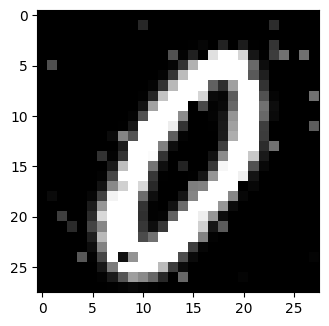

In [118]:
im_idx = random.randint(X_train.shape[0]//2, X_train.shape[0])
print(y_train[im_idx])
print(random.uniform(0, 0.1))
Settings.show_img(X_train[im_idx].reshape(28,28))

In [119]:
cnn = CNN(X_train, y_train, X_test, y_test)

In [120]:
# cnn.train()

In [121]:
model_filename = 'cnn_model_L0-05331331_R45610017.pkl'

# Load the model
with open(model_filename, 'rb') as file:
    cnn = pickle.load(file)

In [122]:
corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]

print()
print("Computing accuracy over test set:")

t = tqdm(range(len(X_test)), leave=True)
for n in t:
    x = X_test[n]
    pred, prob, all_probs = cnn.predict(x, 1, 2, 2)
    digit_count[int(y_test[n])] += 1
    if pred == y_test[n]:
        corr += 1
        digit_correct[pred] += 1

    t.set_description("Acc:%0.2f%%" % (float(corr / (n + 1)) * 100))

print("Overall Accuracy: %.2f" % (float(corr / len(test_data) * 100)))

Acc:94.00%: 100%|██████████| 2000/2000 [03:20<00:00,  9.95it/s]

Overall Accuracy: 94.00


In [123]:
corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]

print()
print("Computing accuracy over test set:")

t = tqdm(range(len(X_test)//2), leave=True)
for n in t:
    x = X_test[n]
    pred, prob, all_probs = cnn.predict(x, 1, 2, 2)
    digit_count[int(y_test[n])] += 1
    if pred == y_test[n]:
        corr += 1
        digit_correct[pred] += 1

    t.set_description("Acc:%0.2f%%" % (float(corr / (n + 1)) * 100))

print("Overall Accuracy: %.2f" % (float(corr / len(test_data) * 2 * 100)))

Acc:97.80%: 100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]

Overall Accuracy: 97.80


Actual Label  8
Model Predicted  8


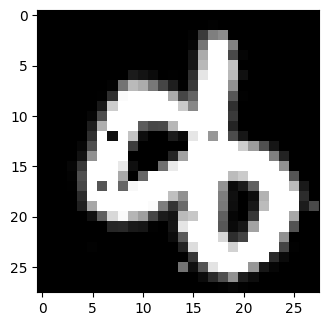

In [124]:
random_num = np.random.randint(X_test.shape[0]//2, X_test.shape[0])
random_image = X_test[random_num]
random_label = int(y_test[random_num])

print("Actual Label ",random_label)
print("Model Predicted ",cnn.predict(random_image)[0])
Settings.show_img(random_image.reshape(28,28))